# Phase 3 Data Science Training Notebook

In [13]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

In [14]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [15]:
data_batch_1 = unpickle("data/data_batch_1")
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

We are interested in b'labels' and b'data'

In [16]:
labelNames = unpickle("data/batches.meta")
labelNames.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [17]:
print(labelNames[b'num_cases_per_batch'])
print(labelNames[b'label_names'])
labelNames.values()

10000
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


dict_values([10000, [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], 3072])

In [18]:
labelList = labelNames[b'label_names']

In [19]:
data_batch_1[b'batch_label']

b'training batch 1 of 5'

In [20]:
print(len(data_batch_1[b'labels']))
print(max(data_batch_1[b'labels']))
print(min(data_batch_1[b'labels']))
labels = data_batch_1[b'labels']

10000
9
0


Now we are going to find the indexes for the first five images of each category so we can display them all in one go. I will be using an inefficient linear search for simplicity.

In [21]:
indexForEach = []
for i in range (10):
    temp = []
    for idx, label in enumerate(labels):
        if len(temp) == 5:
            indexForEach.append(temp)
            break
        if label == i:
            temp.append(idx)

In [22]:
data_batch_1[b'data'].shape

(10000, 3072)

Lets display five images from each label, all coming from data_batch_1

In [23]:
import matplotlib.pyplot as plt

def getFiveImages(toShow, index):
    sampleImages = []
    for i in range (5):
        temp =  data_batch_1[b'data'][toShow[i]]
        temp = temp.reshape(3,32,32)
        temp = temp.transpose(1,2,0)
        sampleImages.append(temp)
    fig, axs = plt.subplots(1, 5, constrained_layout=True)
    fig.suptitle("Label " + index + " (" + str(labelList[int(index)]).replace("b'", "").replace("'", "") + ")", fontsize=16)
    fig.set_figwidth(15)
    for j in range (5):
        axs[j].imshow(sampleImages[j])

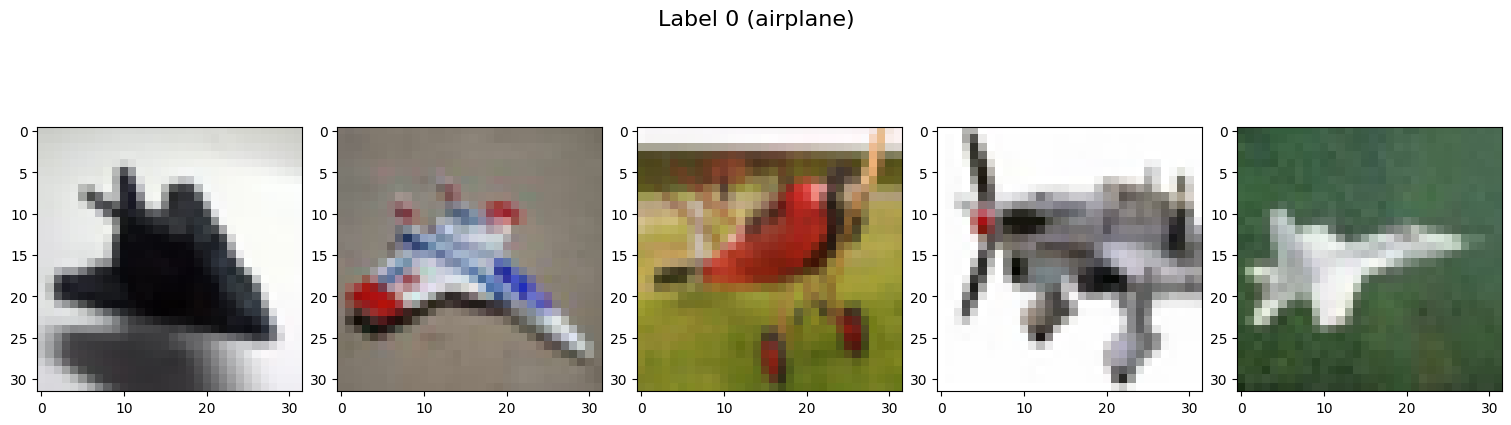

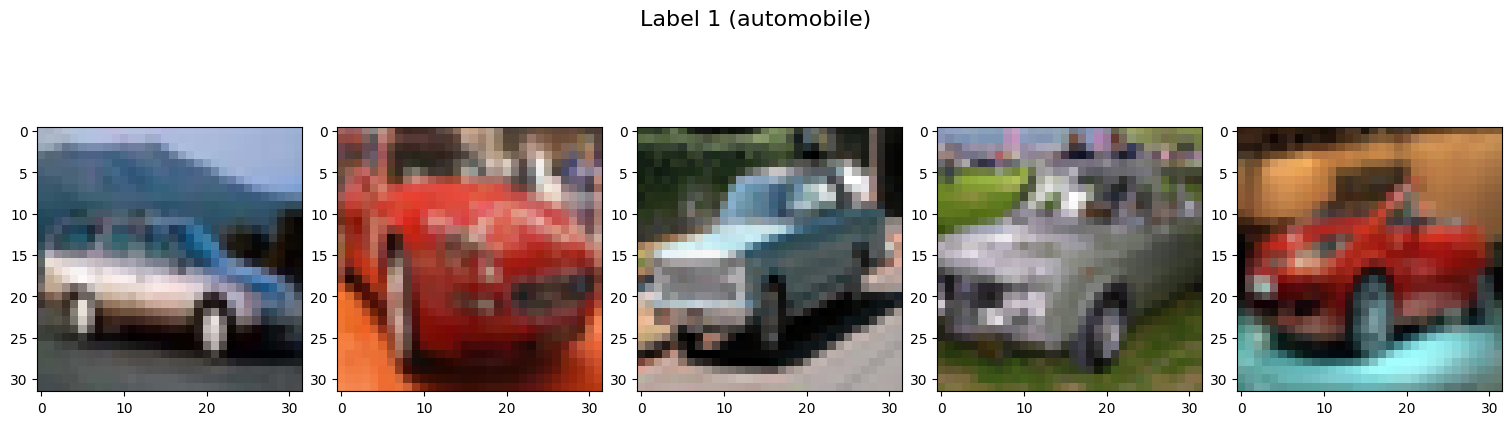

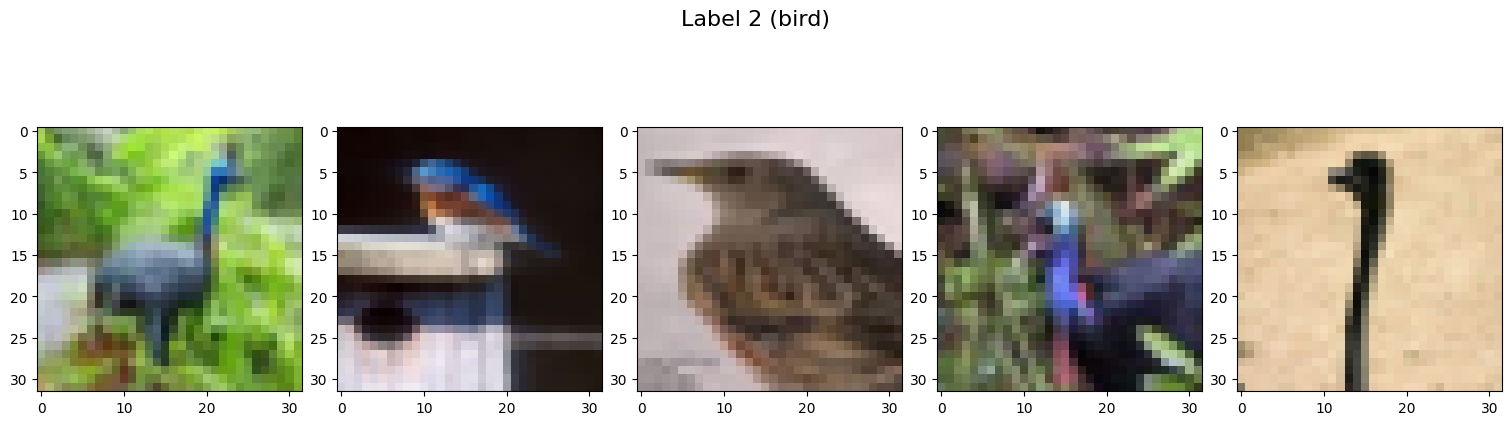

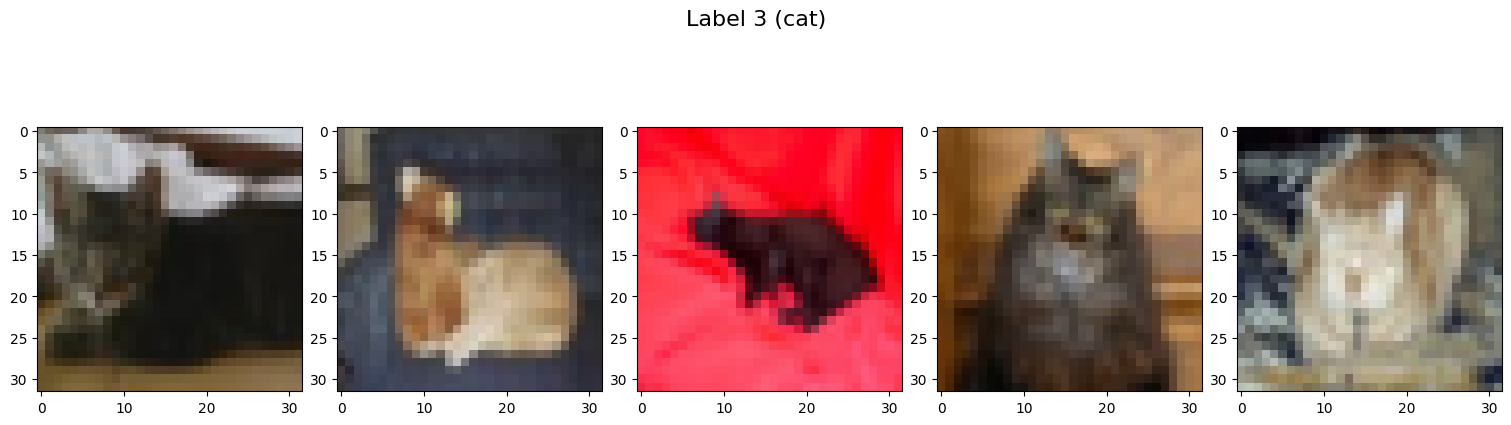

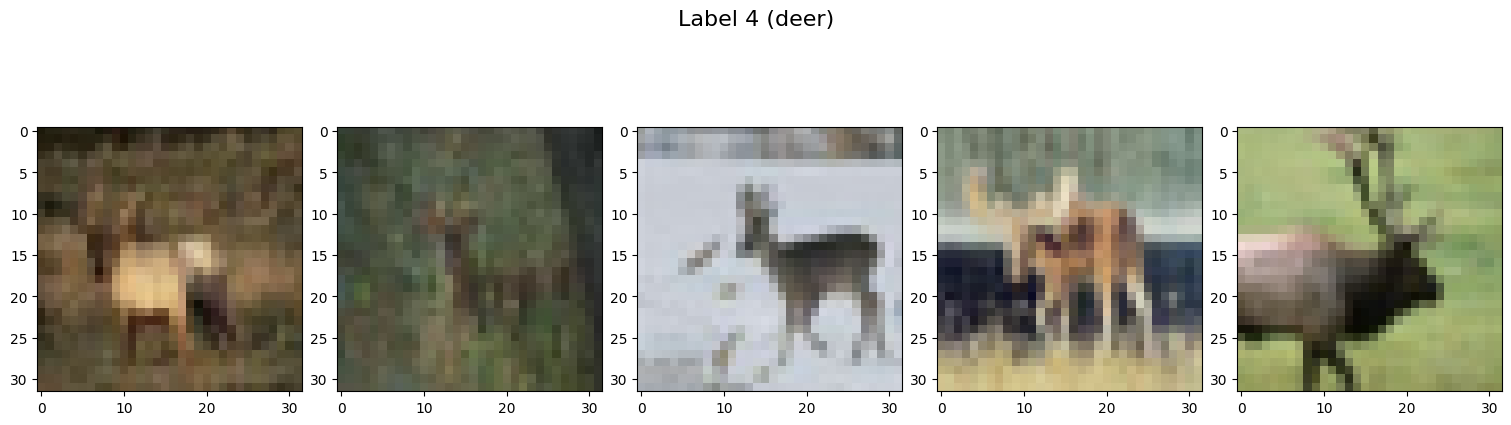

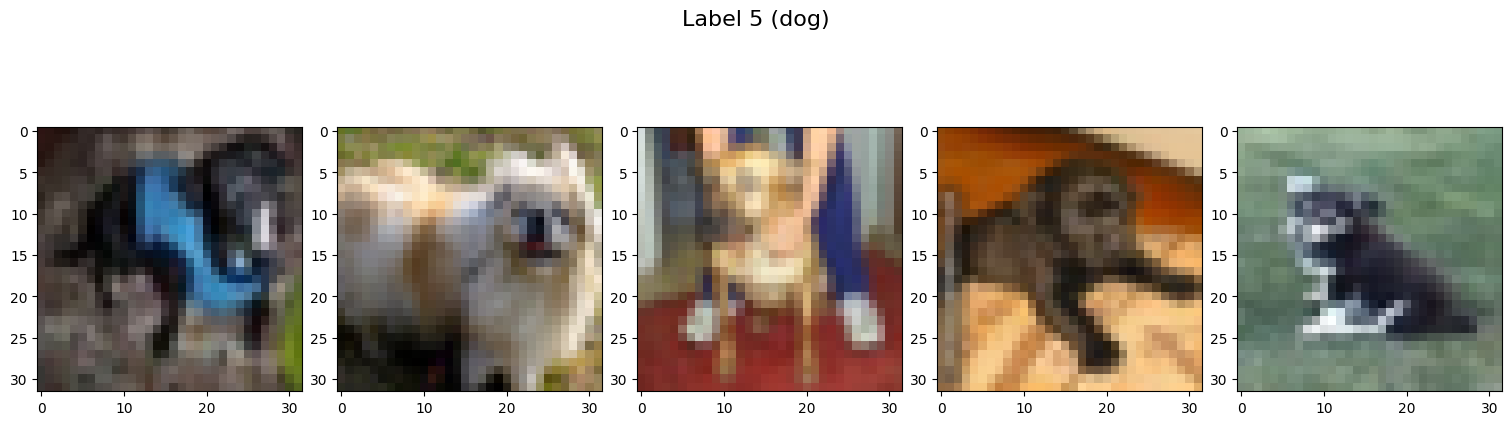

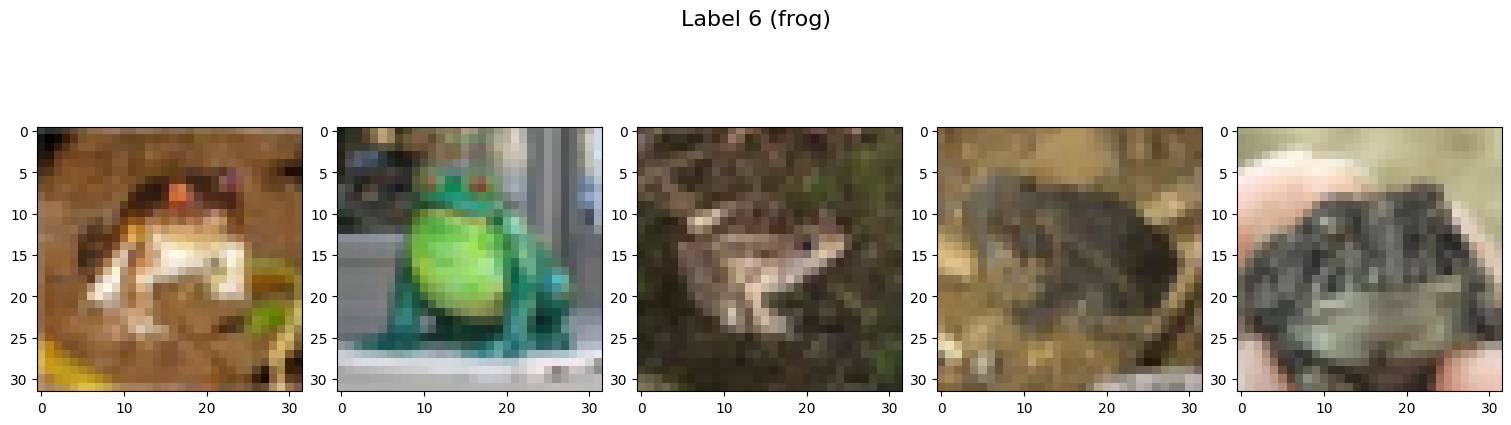

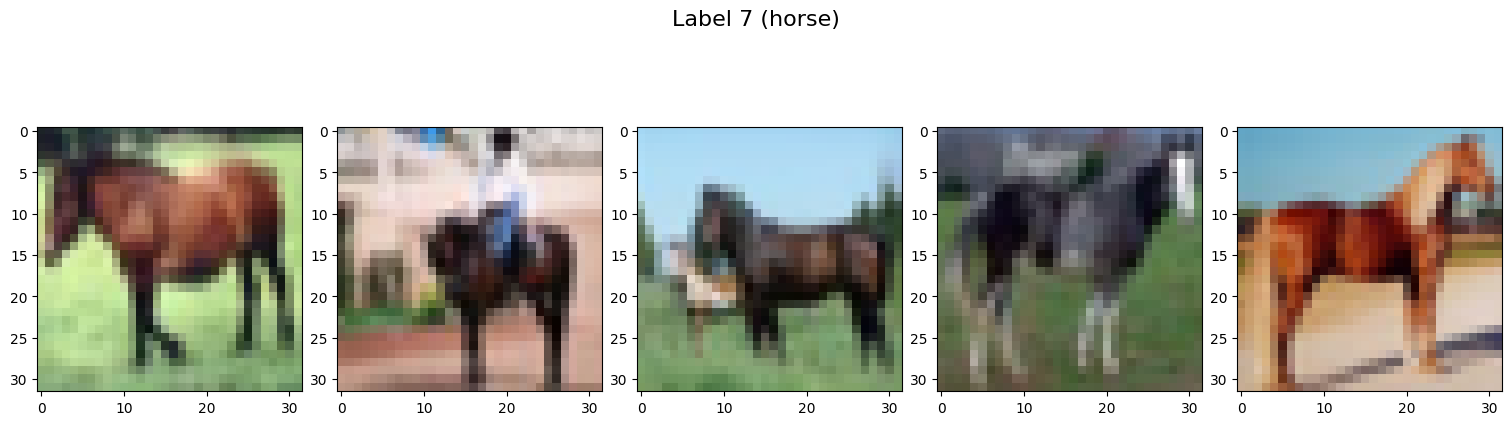

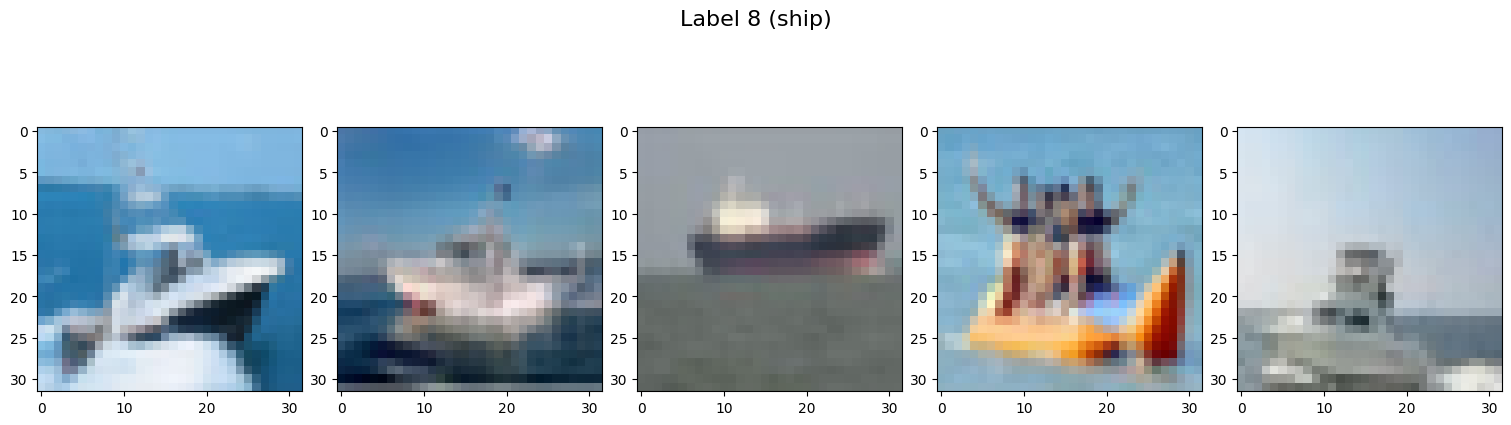

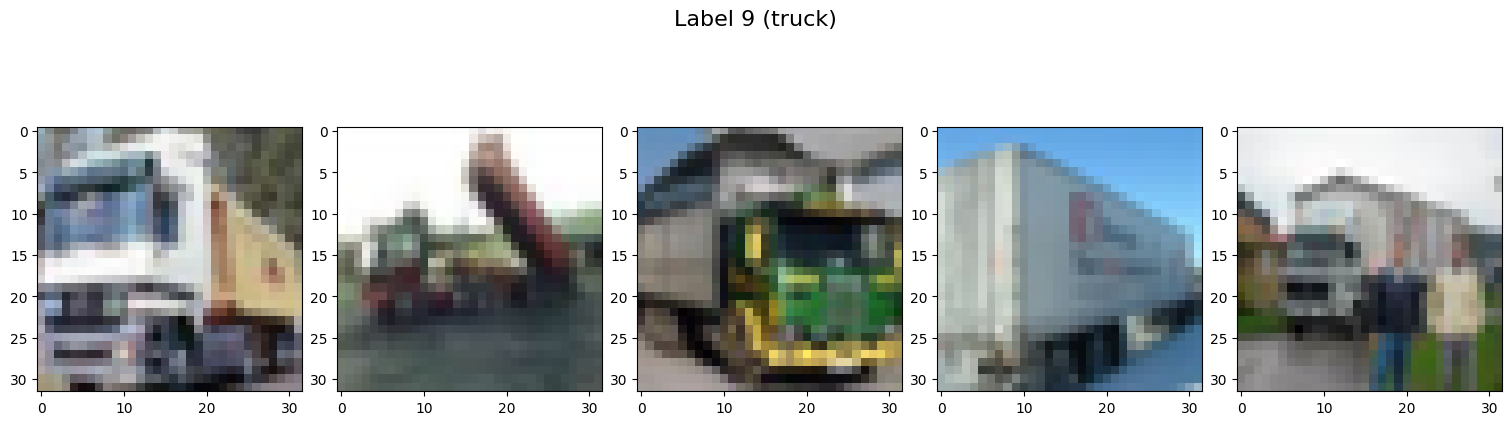

In [24]:
for i in range (10):
    getFiveImages(indexForEach[i], str(i))

I'd like to use label 0, which appears to be 'airplane'

# Data Processing

Now lets unpickle the rest of the files and then see how we can use it to fit a model

In [25]:
testingData = unpickle("data/test_batch")
data_batch_2 = unpickle("data/data_batch_2")
data_batch_3 = unpickle("data/data_batch_3")
data_batch_4 = unpickle("data/data_batch_4")
data_batch_5 = unpickle("data/data_batch_5")


We should combine all the training data together so it makes it easier to tran our model.

In [26]:
batches = []
batches.append(data_batch_1)
batches.append(data_batch_2)
batches.append(data_batch_3)
batches.append(data_batch_4)
batches.append(data_batch_5)

To have usable data, we need to transform the 1d arrays into 3d

In [27]:
def formatData(entry):
    temp = entry
    temp = temp.reshape(3,32,32)
    temp = temp.transpose(1,2,0)
    return temp

In [28]:
combinedTrainData = batches[0][b'data']
combinedTrainLabels = batches[0][b'labels']
for i in range (1,5):
    combinedTrainLabels = np.concatenate((combinedTrainLabels, batches[i][b'labels']))
    combinedTrainData = np.concatenate((combinedTrainData, batches[i][b'data']))
print(len(combinedTrainData))
print(len(combinedTrainLabels))

50000
50000


we should check that there is no data imbalance(ie our target is not overrepresented in the data).

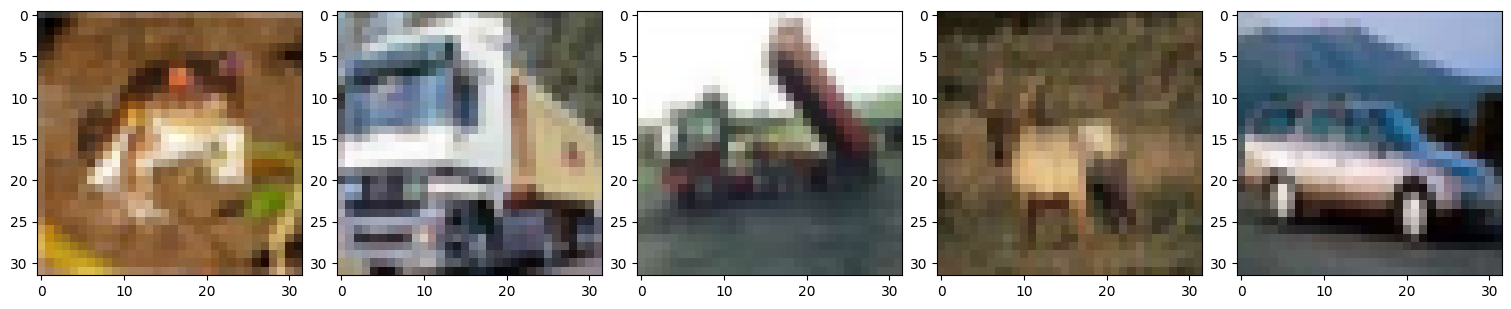

In [29]:
testImages = []
trainImages = []
for val in combinedTrainData:
    trainImages.append(formatData(val)) #getting the correct format to display image
for val in testingData[b'data']:
    testImages.append(formatData(val))


fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figwidth(15)
for j in range (5):
    axs[j].imshow(trainImages[j])

We should convert the data to a format usable by the model

In [30]:
trainingData = np.array(trainImages)
trainingLabels = np.array(combinedTrainLabels)
testingLabels = np.array(testingData[b'labels'])

Since we are only interested in predicting for a chosen label, we should somehow encode or categorise the labels based on if they belong to it or not, as so:

In [31]:
chosenLabel = 0
def formatLabels(array):
    temp = array
    for idx, val in enumerate(array):
        if val != chosenLabel:
            temp[idx] = 0
        else:
            temp[idx] = 1
    return temp

## Checking for data imbalance


In [32]:
list(trainingLabels).count(chosenLabel)

5000

In [33]:
list(testingLabels).count(chosenLabel)

1000

As we can see our data has 5000 labels for training and 1000 for testing, which means we will have 10,000 data entries in total for training while also having 2000 entries for testing. 

In [34]:
from keras.utils import to_categorical

train_x = trainingData
train_y = to_categorical(formatLabels(trainingLabels))
test_x = np.array(testImages)
test_y = to_categorical(formatLabels(testingLabels))

Here we converted the labels into categorical values, so we can use binary crossentropy to determine the probability that a image belongs to the category we are interested in

# Data Modelling

In [35]:
import tensorflow as tf
from tensorflow.keras import Input, Sequential, optimizers, losses, callbacks
from datetime import datetime
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Rescaling
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import SGD
from tensorboard.plugins.hparams import api as hp


In [37]:
log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H%M%S")

In [39]:
HP_OPTIMIZER = hp.HParam('optimzer', hp.Discrete(['adam', 'sgd']))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,0.7))
HP_BATCHSIZE = hp.HParam('batchsize', hp.RealInterval(16.0,64.0))
with tf.summary.create_file_writer('output/logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_OPTIMIZER,HP_DROPOUT, HP_BATCHSIZE],
        metrics=[hp.Metric('accuracy', display_name='accuracy')]
    )

In [45]:
def trainTestModel(hparams):
    model = Sequential(name="Image_Recognition_Model")
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Rescaling(scale=1./255, name="Normaliser")) # pre-processing layer.
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss=losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    model.fit(train_x, train_y,
    batch_size=hparams[HP_BATCHSIZE],
    epochs=1,
    )
    _,accuracy = model.evaluate(test_x, test_y)
    return accuracy

In [41]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = trainTestModel(hparams)
    tf.summary.scalar('accuracy', accuracy, step=1)

In [46]:
session = 0
dropoutRate = HP_DROPOUT.domain.min_value
batchSize = int(HP_BATCHSIZE.domain.min_value)
while batchSize <= int(HP_BATCHSIZE.domain.max_value):
    while dropoutRate <= HP_DROPOUT.domain.max_value:
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_DROPOUT: dropoutRate,
                HP_OPTIMIZER: optimizer,
                HP_BATCHSIZE: batchSize
            }
            run_name = "run-%d" % session
            print("%s" % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('output/logs/hparam_tuning/' + run_name, hparams)
            session+=1
        dropoutRate += 0.1
    batchSize= batchSize*2
                

run-0
{'dropout': 0.2, 'optimzer': 'adam', 'batchsize': 16}
313/313 [==============================] - 4s 14ms/step - loss: 0.1656 - accuracy: 0.9416
run-1
{'dropout': 0.2, 'optimzer': 'sgd', 'batchsize': 16}
313/313 [==============================] - 4s 14ms/step - loss: 0.1883 - accuracy: 0.9285
run-2
{'dropout': 0.30000000000000004, 'optimzer': 'adam', 'batchsize': 16}
313/313 [==============================] - 5s 14ms/step - loss: 0.1740 - accuracy: 0.9351
run-3
{'dropout': 0.30000000000000004, 'optimzer': 'sgd', 'batchsize': 16}
313/313 [==============================] - 6s 19ms/step - loss: 0.1897 - accuracy: 0.9261
run-4
{'dropout': 0.4, 'optimzer': 'adam', 'batchsize': 16}
313/313 [==============================] - 6s 19ms/step - loss: 0.1732 - accuracy: 0.9384
run-5
{'dropout': 0.4, 'optimzer': 'sgd', 'batchsize': 16}
313/313 [==============================] - 4s 14ms/step - loss: 0.1956 - accuracy: 0.9227
run-6
{'dropout': 0.5, 'optimzer': 'adam', 'batchsize': 16}
313/313 [==

Using the data, we can see that adam optimiser with 0.2 dropout seems to yield the best results

In [38]:
def generateModel():
    
    model = Sequential(name="Image_Recognition_Model")
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Rescaling(scale=1./255, name="Normaliser")) #pre processing
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                loss=losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

In [40]:
model = generateModel()

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=16,
    batch_size=16, 
    callbacks=[tensorboard_callback, earlystop_callback],
)

model.save('final_model.h5')

Epoch 1/16
3125/3125 [==============================] - 99s 31ms/step - loss: 0.2156 - accuracy: 0.9217 - val_loss: 0.1739 - val_accuracy: 0.9319
Epoch 2/16
3125/3125 [==============================] - 181s 58ms/step - loss: 0.1611 - accuracy: 0.9409 - val_loss: 0.1427 - val_accuracy: 0.9448
Epoch 3/16
3125/3125 [==============================] - 183s 59ms/step - loss: 0.1364 - accuracy: 0.9494 - val_loss: 0.2193 - val_accuracy: 0.9286
Epoch 4/16
3125/3125 [==============================] - 203s 65ms/step - loss: 0.1191 - accuracy: 0.9556 - val_loss: 0.1382 - val_accuracy: 0.9434
Epoch 5/16
3125/3125 [==============================] - 150s 48ms/step - loss: 0.1035 - accuracy: 0.9605 - val_loss: 0.1275 - val_accuracy: 0.9535
Epoch 6/16
3125/3125 [==============================] - 112s 36ms/step - loss: 0.0927 - accuracy: 0.9651 - val_loss: 0.1540 - val_accuracy: 0.9548
Epoch 7/16
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0795 - accuracy: 0.9702 - val_loss: 0.

In [1]:
from manualpredict import predictForImage, load_img

1/1 [==============================] - 0s 81ms/step
It is probably airplane with a 1.0 chance of being airplane
[[2.623059e-13 1.000000e+00]]


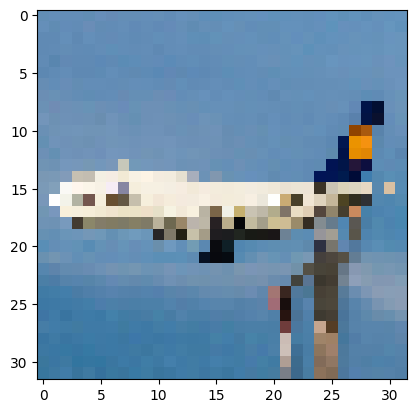

In [12]:
predictForImage('testexamples/plane.jpg') # you can replace with your own image